# Worksheet 09

Name:  Kyran Chen
UID: U51754657

### Topics

- Singular Value Decomposition

#### Feature Extraction

SVD finds features that are orthogonal. The Singular Values correspond to the importance of the feature or how much variance in the data it captures.

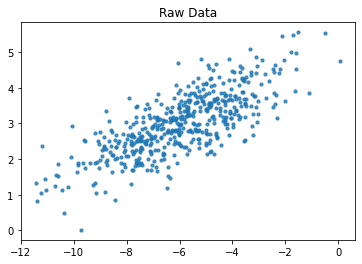

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n_samples = 500
C = np.array([[0.1, 0.6], [2., .6]])
X = np.random.randn(n_samples, 2) @ C + np.array([-6, 3])
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.8)
plt.title("Raw Data")
plt.show()

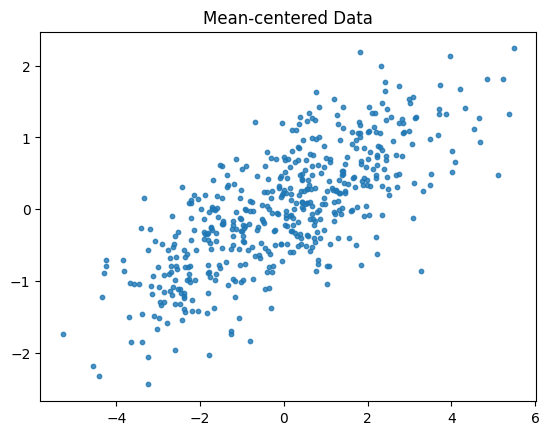

In [3]:
X = X - np.mean(X, axis=0)
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.8)
plt.title("Mean-centered Data")
plt.show()

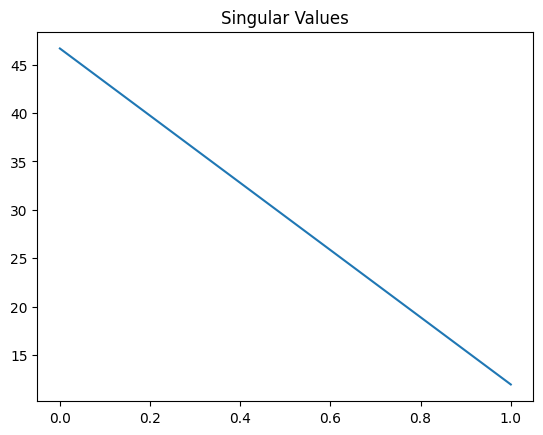

In [8]:
u,s,vt=np.linalg.svd(X, full_matrices=False)
plt.plot(s) # only 2 singular values
plt.title("Singular Values")
plt.show()

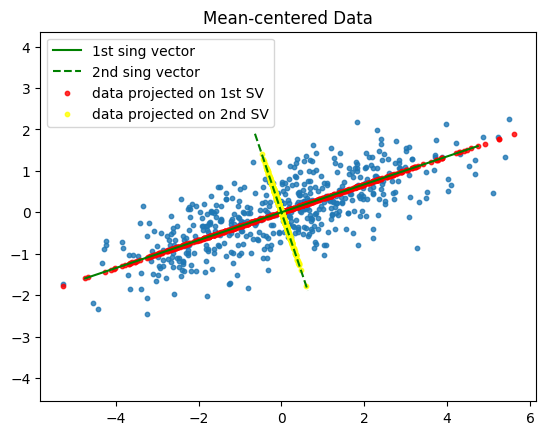

In [12]:
scopy0 = s.copy()
scopy1 = s.copy()
scopy0[1:] = 0.0
scopy1[:1] = 0.0
approx0 = u.dot(np.diag(scopy0)).dot(vt)
approx1 = u.dot(np.diag(scopy1)).dot(vt)
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.8)
sv1 = np.array([[-5],[5]]) @ vt[[0],:]
sv2 = np.array([[-2],[2]]) @ vt[[1],:]
plt.plot(sv1[:,0], sv1[:,1], 'g-', label="1st sing vector")
plt.plot(sv2[:,0], sv2[:,1], 'g--', label="2nd sing vector")
plt.scatter(approx0[:, 0] , approx0[:, 1], s=10, alpha=0.8, color="red", label="data projected on 1st SV")
plt.scatter(approx1[:, 0] , approx1[:, 1], s=10, alpha=0.8, color="yellow", label="data projected on 2nd SV")
plt.axis('equal')
plt.legend()
plt.title("Mean-centered Data")
plt.show()


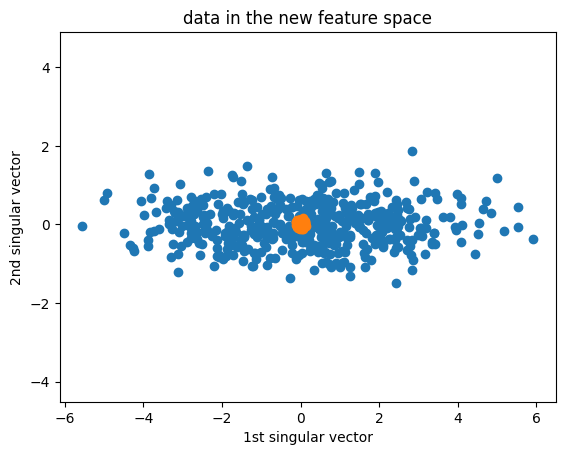

In [20]:
# show ouput from svd is the same
orthonormal_X = u
shifted_X = u.dot(np.diag(s))
plt.axis('equal')
plt.scatter(shifted_X[:,0], shifted_X[:,1])
plt.scatter(orthonormal_X[:,0], orthonormal_X[:,1])
plt.xlabel("1st singular vector")
plt.ylabel("2nd singular vector")
plt.title("data in the new feature space")
plt.show()

### Why you should care

a) By using an approximation of the data, you can improve the performance of classification tasks since:

1. there is less noise interfering with classification
2. no relationship between features after SVD
3. the algorithm is sped up when reducing the dimension of the dataset

Below is some code to perform facial recognition on a dataset. Notice that, applied blindly, it does not perform well:

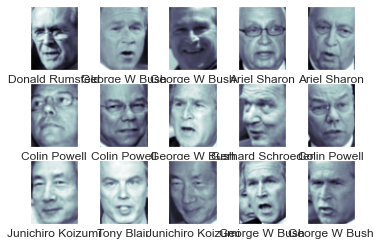

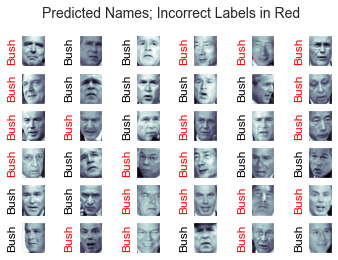

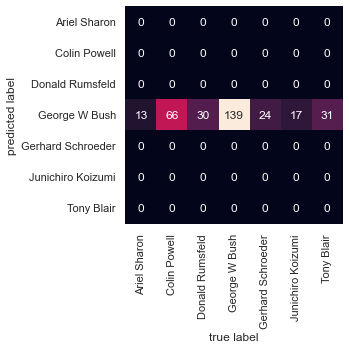

Accuracy =  0.434375


In [5]:
import numpy as np
from PIL import Image
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import fetch_lfw_people
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

sns.set()

# Get face data
faces = fetch_lfw_people(min_faces_per_person=60)

# plot face data
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])
plt.show()

# split train test set
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)

# blindly fit svm
svc = SVC(kernel='rbf', class_weight='balanced', C=5, gamma=0.001)

# fit model
model = svc.fit(Xtrain, ytrain)
yfit = model.predict(Xtest)

fig, ax = plt.subplots(6, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.show()

mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

print("Accuracy = ", accuracy_score(ytest, yfit))

By performing SVD before applying the classification tool, we can reduce the dimension of the dataset.

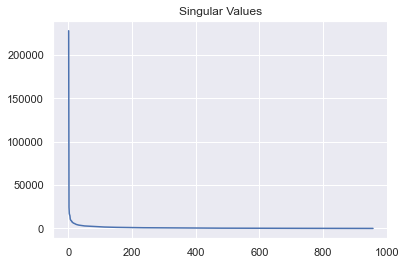

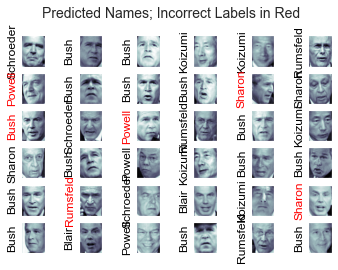

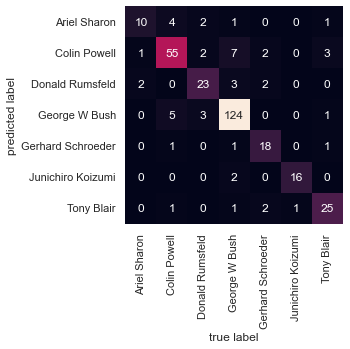

Accuracy =  0.846875


In [6]:
# look at singular values
_, s, _ = np.linalg.svd(Xtrain, full_matrices=False)
plt.plot(range(1,len(s)+1),s)
plt.title("Singular Values")
plt.show()

# extract principal components
pca = PCA(n_components=150, whiten=True)
svc = SVC(kernel='rbf', class_weight='balanced', C=5, gamma=0.001)
svcpca = make_pipeline(pca, svc)
model = svcpca.fit(Xtrain, ytrain)
yfit = model.predict(Xtest)

fig, ax = plt.subplots(6, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.show()

mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

print("Accuracy = ", accuracy_score(ytest, yfit))

Similar to finding k in K-means, we're trying to find the point of diminishing returns when picking the number of singular vectors (also called principal components).

b) SVD can be used for anomaly detection.

The data below consists of the number of 'Likes' during a six month period, for each of 9000 users across the 210 content categories that Facebook assigns to pages.

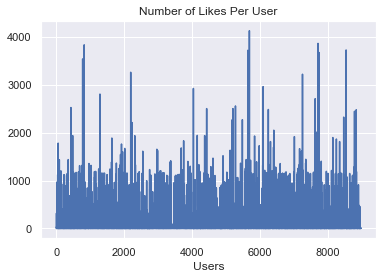

In [8]:
data = np.loadtxt('./spatial_data.txt')

FBSpatial = data[:,1:]
FBSnorm = np.linalg.norm(FBSpatial,axis=1,ord=1)
plt.plot(FBSnorm)
plt.title('Number of Likes Per User')
_ = plt.xlabel('Users')
plt.show()

How users distribute likes across categories follows a general pattern that most users follow. This behavior can be captured using few singular vectors. And anomalous users can be easily identified.

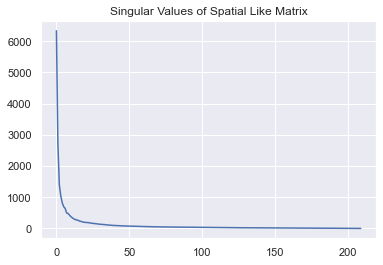

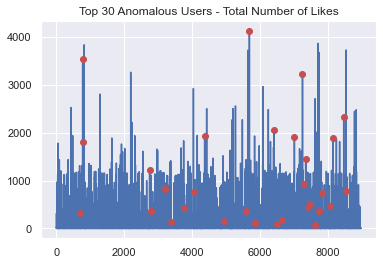

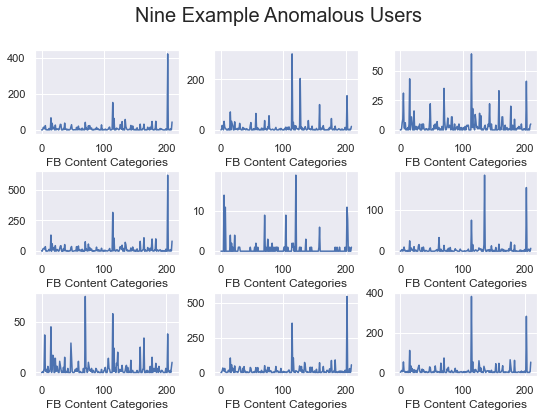

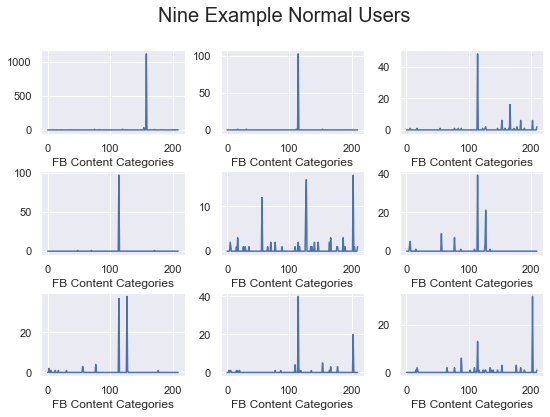

In [12]:

u,s,vt = np.linalg.svd(FBSpatial,full_matrices=False)
plt.plot(s)
_ = plt.title('Singular Values of Spatial Like Matrix')
plt.show()

RANK = 75
scopy = s.copy()
scopy[RANK:] = 0.
N = u @ np.diag(scopy) @ vt
O = FBSpatial - N
Onorm = np.linalg.norm(O, axis=1)
anomSet = np.argsort(Onorm)[-30:]
# plt.plot(Onorm)
# plt.plot(anomSet, Onorm[anomSet],'ro')
# _ = plt.title('Norm of Residual (rows of O)')
# plt.show()

plt.plot(FBSnorm)
plt.plot(anomSet, FBSnorm[anomSet],'ro')
_ = plt.title('Top 30 Anomalous Users - Total Number of Likes')
plt.show()

# anomalous users
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[anomSet[i-1],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
_ = plt.suptitle('Nine Example Anomalous Users',size=20)
plt.show()

# normal users
set = np.argsort(Onorm)[0:7000]
# that have high overall volume
max = np.argsort(FBSnorm[set])[::-1]
plt.figure(figsize=(9,6))
for i in range(1,10):
    ax = plt.subplot(3,3,i)
    plt.plot(FBSpatial[set[max[i-1]],:])
    plt.xlabel('FB Content Categories')
plt.subplots_adjust(wspace=0.25,hspace=0.45)
_ = plt.suptitle('Nine Example Normal Users',size=20)
plt.show()

### Latent Semantic Analysis

In this section we will fetch news articles from 3 different categories. We will perform Tfidf vectorization on the corpus of documents and use SVD to represent our corpus in the feature space of topics that we've uncovered from SVD. We will attempt to cluster the documents into 3 clusters as we vary the number of singular vectors we use to represent the corpus, and compare the output to the clustering created by the news article categories. Do we end up with a better clustering the more singular vectors we use?

[nltk_data] Downloading package punkt to /Users/kyranchen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kyranchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


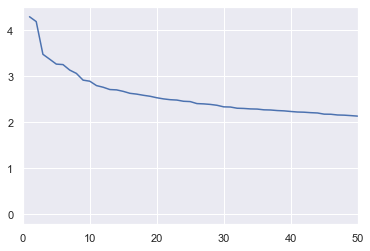

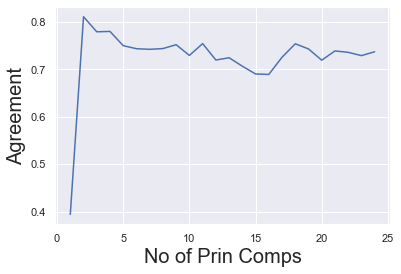

In [16]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

import nltk
nltk.download('punkt')
nltk.download('stopwords')

categories = ['comp.os.ms-windows.misc', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)
vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)

stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
         for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in news_data.data]

dtm = vectorizer.fit_transform(stemmed_data)
terms = vectorizer.get_feature_names()
centered_dtm = dtm - np.mean(dtm, axis=0)

u, s, vt = np.linalg.svd(centered_dtm)
plt.xlim([0,50])
plt.plot(range(1,len(s)+1),s)
plt.show()

ag = []
max = len(u)
for k in range(1,25):
    vectorsk = u.dot(np.diag(s))[:,:k]
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit_predict(np.asarray(vectorsk))
    labelsk = kmeans.labels_
    ag.append(metrics.v_measure_score(labelsk, news_data.target)) # closer to 1 means closer to news categories

plt.plot(range(1,25),ag)
plt.ylabel('Agreement',size=20)
plt.xlabel('No of Prin Comps',size=20)
plt.show()
